In [80]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame 

import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
%matplotlib inline
from matplotlib.pyplot import figure

from datetime import datetime, timedelta 
from statsmodels.tsa.arima_model import ARIMA 

from sklearn.preprocessing import StandardScaler
# import os

In [4]:
test = pd.read_csv("data/test.csv", sep = ",")
train = pd.read_csv("data/train.csv", sep =",")

In [100]:
submission = pd.read_csv("data/submission.csv")

In [5]:
changed_train = pd.read_csv("data/train_DHWeight_onDacon.csv", sep=',')
changed_test = pd.read_csv("data/test_DHWeight_onDacon.csv", sep=',')

In [53]:
changed_test['Time'] = pd.to_datetime(changed_test['Time']) 
changed_test = changed_test.set_index('Time')

In [63]:
idx = changed_test.count(axis = 'columns') >= 201*0.5
ch_te_TimeCut = changed_test[idx]

In [47]:
# hourly WEATHER data
w_hr = pd.read_csv("data/weather/인천_시간별__기상자료(16-18)_축소__7월1일.csv",encoding='euc-kr', sep=',')
w_hr2 = w_hr.loc[:,['일시', '기온(°C)', '강수량(mm)', '풍속(m/s)']]
w_hr2['강수량(mm)']=w_hr2.loc[:,'강수량(mm)'].fillna(0)
old = w_hr2.columns
new = ['Time', 'Temp', 'Precipitation', 'Wind']
w_hr2 = w_hr2.rename(columns=dict(zip(old, new)))
w_hr2.Time = pd.to_datetime(w_hr2.Time)
w_hr2.set_index('Time')

,Temp,Precipitation,Wind
Time,,,
2016-07-20 00:00:00,25.7,0.0,1.3
2016-07-20 01:00:00,25.6,0.0,1.4
2016-07-20 02:00:00,25.4,0.0,0.3
2016-07-20 03:00:00,24.9,0.0,1.1
2016-07-20 04:00:00,24.7,0.0,0.7
...,...,...,...
2018-07-01 19:00:00,21.6,1.8,5.1
2018-07-01 20:00:00,21.4,1.3,5.0
2018-07-01 21:00:00,21.3,4.2,4.5


In [114]:
# daily WEATHER data
w_daily = pd.read_csv("data/weather/인천_일별_기상자료(16-18)_축소.csv",encoding='euc-kr', sep=',')
w_daily2 = w_daily.iloc[:,1:5]
old = w_daily2.columns
new = ['Time', 'AvgT', 'MinT', 'MaxT']
w_daily2 = w_daily2.rename(columns=dict(zip(old, new)))
w_daily2.Time = pd.to_datetime(w_daily2.Time)
w_daily2.set_index('Time')

,AvgT,MinT,MaxT
Time,,,
2016-07-20,28.1,24.6,31.6
2016-07-21,28.0,25.0,31.5
2016-07-22,28.5,25.9,32.3
2016-07-23,27.7,25.8,30.2
2016-07-24,27.0,26.4,28.9
...,...,...,...
2018-07-06,24.4,22.4,27.4
2018-07-07,23.9,19.4,28.7
2018-07-08,23.4,18.9,27.3


In [67]:
len(ch_te_TimeCut.to_numpy())

7016

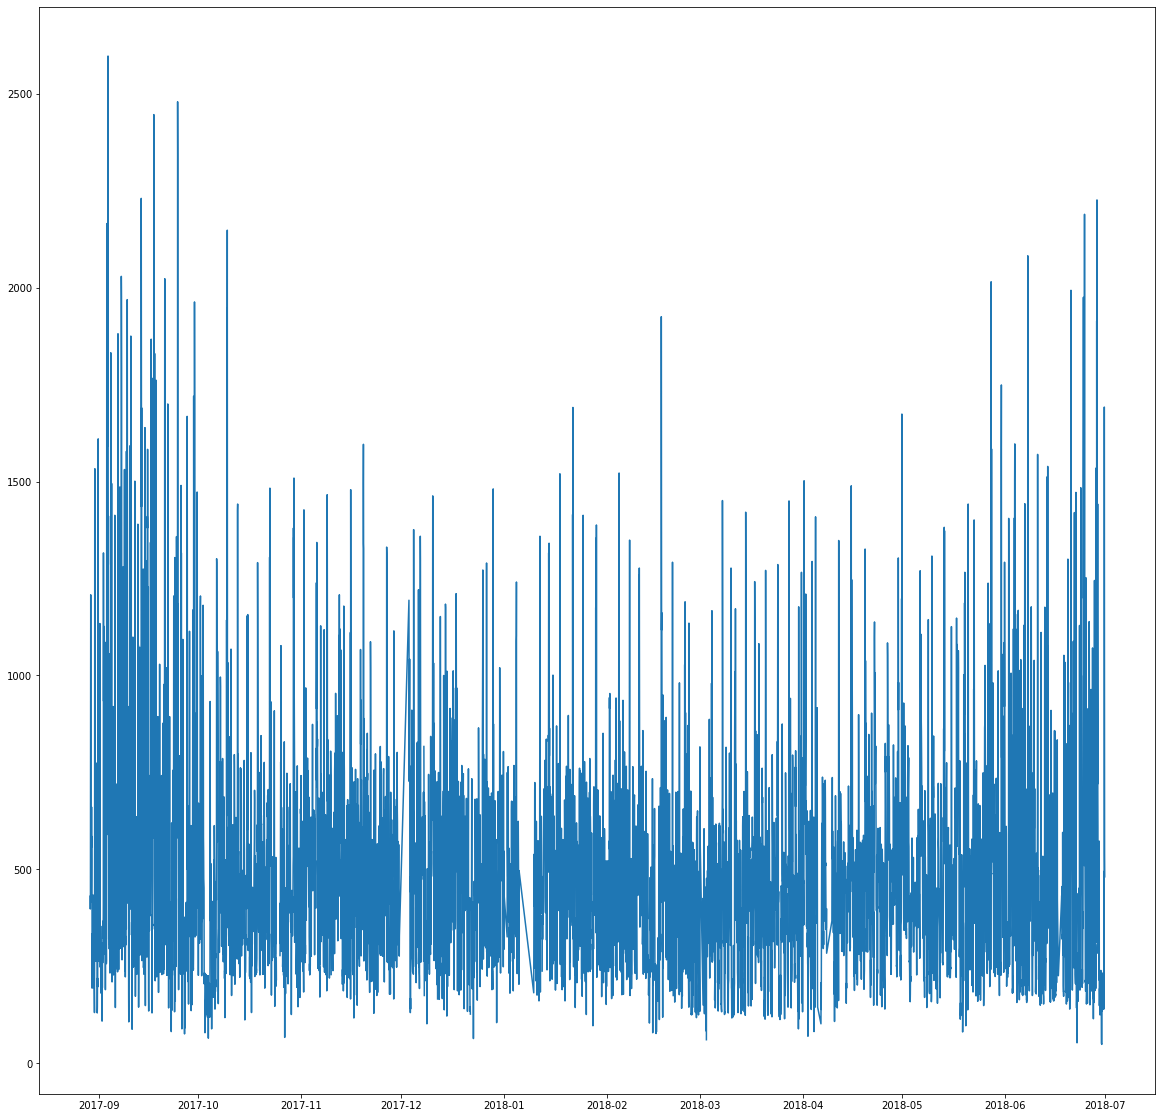

In [87]:
X303 = ch_te_TimeCut.iloc[:, [1]]
# kw -> watt 변환
X303 = X303*1000

figure(figsize=(20,20))
plt.plot(X303)

In [89]:
X303.head()

,X303
Time,
2017-08-29 10:00:00,431.0
2017-08-29 11:00:00,398.0
2017-08-29 12:00:00,427.0
2017-08-29 13:00:00,727.0
2017-08-29 14:00:00,1208.0


In [99]:
scaler = StandardScaler()
normalized = scaler.fit(X303).transform(X303)

In [ ]:
# ##  우선 random sample generator 는 스킵한다
# def generator(data, lookback, delay, min_index, max_index,
#               shuffle=False, batch_size=128, step=6):
#     if max_index is None:
#         max_index = len(data) - delay - 1
#     i = min_index + lookback
#     while 1:
#         if shuffle:
#             rows = np.random.randint(
#                 min_index + lookback, max_index, size=batch_size)
#         else:
#             if i + batch_size >= max_index:
#                 i = min_index + lookback
#             rows = np.arange(i, min(i + batch_size, max_index))
#             i += len(rows)

#         samples = np.zeros((len(rows),
#                            lookback // step,
#                            data.shape[-1]))
#         targets = np.zeros((len(rows),))
#         for j, row in enumerate(rows):
#             indices = range(rows[j] - lookback, rows[j], step)
#             samples[j] = data[indices]
#             targets[j] = data[rows[j] + delay][1]
#         yield samples, targets
# # 코드 6-34 후련, 검증, 테스트 제너레이터 준비하기
# lookback = 1440
# step = 6
# delay = 144
# batch_size = 128

# train_gen = generator(float_data,
#                       lookback=lookback,
#                       delay=delay,
#                       min_index=0,
#                       max_index=200000,
#                       shuffle=True,
#                       step=step,
#                       batch_size=batch_size)
# val_gen = generator(float_data,
#                     lookback=lookback,
#                     delay=delay,
#                     min_index=200001,
#                     max_index=300000,
#                     step=step,
#                     batch_size=batch_size)
# test_gen = generator(float_data,
#                      lookback=lookback,
#                      delay=delay,
#                      min_index=300001,
#                      max_index=None,
#                      step=step,
#                      batch_size=batch_size)

# # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
# val_steps = (300000 - 200001 - lookback) // batch_size

# # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
# test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [106]:
X_test_time = submission.columns[1:]

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='smape')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)